# LSTM予測による異常検知

In [15]:
i

  ERROR: Could not find a version that satisfies the requirement renom (from versions: none)
ERROR: No matching distribution found for renom


In [16]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

#https://www.renom.jp/ja/index.html からインストールする
import renom as rm
#from renom.optimizer import Adam
#from renom.cuda import set_cuda_active


ModuleNotFoundError: No module named 'renom'

## データ

In [10]:
df = pd.read_csv('data/qtdbsel102.txt', header=None, delimiter='\t')
ecg = df.iloc[:,2].values
ecg = ecg.reshape(len(ecg), -1)
print('length of ECG data : ', len(ecg))

# standardize
scaler = StandardScaler()
std_ecg = scaler.fit_transform(ecg)

#plt.style.use('ggplot')
#plt.figure(figsize=(15,5))
#plt.xlabel('time')
#plt.ylabel('ECG\'s value')
#plt.plot(np.arange(5000), std_ecg[:5000], color='b')
#plt.ylim(-3, 3)
#x = np.arange(4200,4400)
#y1 = [-3]*len(x)
#y2 = [3]*len(x)
#plt.fill_between(x, y1, y2, facecolor='g', alpha=.3)
#plt.show()

length of ECG data :  45000


In [11]:
#正常データは最初の5000ポイントまで
normal_cycle = std_ecg[5000:]


In [12]:
#部分列の作成関数
def create_subseq(ts, look_back, pred_length):
    sub_seq, next_values = [], []
    for i in range(len(ts)-look_back-pred_length):  
        sub_seq.append(ts[i:i+look_back])
        next_values.append(ts[i+look_back:i+look_back+pred_length].T[0])
    return sub_seq, next_values

### データセットの作成

In [13]:
look_back = 10
pred_length = 3

sub_seq, next_values = create_subseq(normal_cycle, look_back, pred_length)


X_train, X_test, y_train, y_test = train_test_split(
    sub_seq, next_values, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


train_size = X_train.shape[0]
test_size = X_test.shape[0]
print('train size:{}, test size:{}'.format(train_size, test_size))

train size:31989, test size:7998


In [14]:
# model definition
model = rm.Sequential([
    rm.Lstm(35),
    rm.Relu(),
    rm.Lstm(35),
    rm.Relu(),
    rm.Dense(pred_length)
    ])


NameError: name 'rm' is not defined

In [21]:
# params
batch_size = 100
max_epoch = 2000
period = 10 # early stopping checking period
optimizer = Adam()

epoch:10 train loss:0.0068270740424776245 test loss:0.006215366069227457
epoch:20 train loss:0.004714541742651137 test loss:0.00416744826361537
epoch:30 train loss:0.004174038645195363 test loss:0.00391348684206605
epoch:40 train loss:0.003649905636004496 test loss:0.0035140670370310545
epoch:50 train loss:0.003166048928765364 test loss:0.002928102621808648
epoch:60 train loss:0.002905777365051 test loss:0.0027830444741994143
epoch:70 train loss:0.002622409238513606 test loss:0.00296232127584517
Stop learning


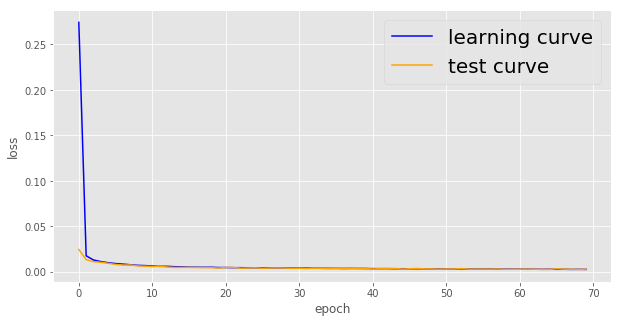

In [22]:
# Train Loop
epoch = 0
loss_prev = np.inf

learning_curve, test_curve = [], []

while(epoch < max_epoch):
    epoch += 1

    perm = np.random.permutation(train_size)
    train_loss = 0

    for i in range(train_size // batch_size):
        batch_x = X_train[perm[i*batch_size:(i+1)*batch_size]]
        batch_y = y_train[perm[i*batch_size:(i+1)*batch_size]]

        # Forward propagation
        l = 0
        z = 0
        with model.train():
            for t in range(look_back):
                z = model(batch_x[:,t])
                l = rm.mse(z, batch_y)
            model.truncate()
        l.grad().update(optimizer)
        train_loss += l.as_ndarray()

    train_loss /= (train_size // batch_size)
    learning_curve.append(train_loss)

    # test
    l = 0
    z = 0
    for t in range(look_back):
        z = model(X_test[:,t])
        l = rm.mse(z, y_test)
    model.truncate()
    test_loss = l.as_ndarray()
    test_curve.append(test_loss)

    # check early stopping
    if epoch % period == 0:
        print('epoch:{} train loss:{} test loss:{}'.format(epoch, train_loss, test_loss))
        if test_loss > loss_prev*0.99:
            print('Stop learning')
            break
        else:
            loss_prev = deepcopy(test_loss)

plt.figure(figsize=(10,5))
plt.plot(learning_curve, color='b', label='learning curve')
plt.plot(test_curve, color='orange', label='test curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(fontsize=20)
plt.show()

In [23]:
# computing errors
for t in range(look_back):
    pred = model(X_test[:,t])
model.truncate()
errors = y_test - pred

mean = sum(errors)/len(errors)

cov = 0
for e in errors:
    cov += np.dot((e-mean).reshape(len(e), 1), (e-mean).reshape(1, len(e)))
cov /= len(errors)

print('mean : ', mean)
print('cov : ', cov)

mean :  [0.00098557 0.00251453 0.00226544]
cov :  [[0.00072519 0.00070102 0.00060695]
 [0.00070102 0.0016201  0.00176245]
 [0.00060695 0.00176245 0.00356692]]


In [24]:
# calculate Mahalanobis distance
def Mahala_distantce(x,mean,cov):
    d = np.dot(x-mean,np.linalg.inv(cov))
    d = np.dot(d, (x-mean).T)
    return d

# anomaly detection
sub_seq, next_values = create_subseq(std_ecg[:5000], look_back, pred_length)
sub_seq = np.array(sub_seq)
next_values = np.array(next_values)

for t in range(look_back):
    pred = model(sub_seq[:,t])
model.truncate()
errors = next_values - pred

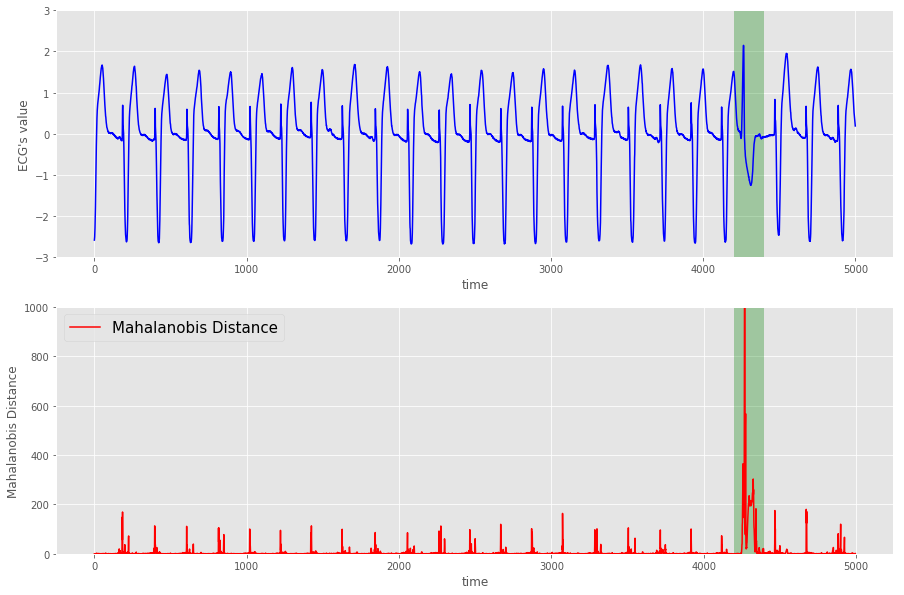

In [25]:
m_dist = [0]*look_back 
for e in errors:
    m_dist.append(Mahala_distantce(e,mean,cov))

fig, axes = plt.subplots(nrows=2, figsize=(15,10))

axes[0].plot(std_ecg[:5000],color='b',label='original data')
axes[0].set_xlabel('time')
axes[0].set_ylabel('ECG\'s value' )
axes[0].set_ylim(-3, 3)
x = np.arange(4200,4400)
y1 = [-3]*len(x)
y2 = [3]*len(x)
axes[0].fill_between(x, y1, y2, facecolor='g', alpha=.3)

axes[1].plot(m_dist, color='r',label='Mahalanobis Distance')
axes[1].set_xlabel('time')
axes[1].set_ylabel('Mahalanobis Distance')
axes[1].set_ylim(0, 1000)
y1 = [0]*len(x)
y2 = [1000]*len(x)
axes[1].fill_between(x, y1, y2, facecolor='g', alpha=.3)

plt.legend(fontsize=15)
plt.show()
